In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, Reshape, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from glob import glob
from data_parsing import load_trajectories

In [2]:
trajectories = load_trajectories('data/MITxPRO+AMxB+1T2018/edges')

In [3]:
# complete course structure and module descriptions
# list of student identifiers and performance statistics, certification, and enrollment data
# problem UTF-encoding error

AM_modules = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-modules.txt', sep='\t', encoding='utf-16')
len(AM_modules)

1121

In [4]:
# session level edge data
AM_edges_sessionLevel01 = pd.read_csv('data/MITxPRO+AMxB+1T2018/edges/MITxPRO+AMxB+1T2018-stdAgg-edgeList-sessionLevel-1.csv')
#AM_edges_sessionLevel01[AM_edges_sessionLevel01['user_id'] == 15779327][100:150

3483

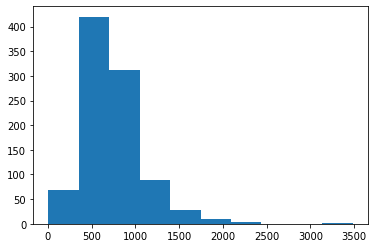

In [5]:
# # for each student this is list of numerical id's for the URLs - removing duplicates
# def get_trajectory(df):
#     order = [0]
#     for url in df['order']:
#         if url != order[-1]:
#             order.append(url)
#     order.append(0)
#     return order

# trajectories = []

# for fname in glob('data/MITxPRO+AMxB+1T2018/edges/*.csv'):
#     df = pd.read_csv(fname)
#     trajectories.append(df)
    
# trajectories = pd.concat(trajectories)
# trajectories = trajectories.groupby('user_id').apply(get_trajectory)
traj_lengths = trajectories.map(len).values

plt.hist(traj_lengths)
max(traj_lengths)
#trajectories[:25]

In [9]:
incoming_traj = []
outgoing_traj = []
n_train = 800
n_valid = 130

for traj in trajectories.values:
    incoming_traj.append(np.array(traj[:-1]).reshape(1,-1))
    outgoing_traj.append(np.array(traj[1:]).reshape(-1,1))

index = np.arange(len(trajectories))
np.random.seed(9)
np.random.shuffle(index)
    
def train_generator():
    while True:
        for i in range(0, n_train):
            x = incoming_traj[index[i]].reshape(1,-1)
            y = outgoing_traj[index[i]].reshape(1,-1)
            yield x,y
            
def valid_generator():
    while True:
        for i in range(n_train, n_train+n_valid):
            x = incoming_traj[index[i]].reshape(1,-1)
            y = outgoing_traj[index[i]].reshape(1,-1)
            yield x,y

In [10]:
hidden_dim = 37
embedding_dim = 30
number_of_URL = 1121
optimizer = Adam(learning_rate=0.001)

input_ = Input(shape=(None,))
embed = Embedding(number_of_URL, embedding_dim, name='URL_embedding')(input_)

#return_sequences = true bc we want the whole sequence returned at every step in the series
rnn = LSTM(hidden_dim, return_sequences=True, name='LSTM')(embed)

predicted_URL = Dense(number_of_URL, activation = 'softmax', name='Predicted_URL')(rnn)

model = Model(inputs=input_, outputs=predicted_URL)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
URL_embedding (Embedding)    (None, None, 30)          33630     
_________________________________________________________________
LSTM (LSTM)                  (None, None, 37)          10064     
_________________________________________________________________
Predicted_URL (Dense)        (None, None, 1121)        42598     
Total params: 86,292
Trainable params: 86,292
Non-trainable params: 0
_________________________________________________________________


In [8]:
incoming_traj = []
outgoing_traj = []
n_train = 800
n_valid = 130

for traj in trajectories.values:
    incoming_traj.append(np.array(traj[:-1]).reshape(1,-1))
    outgoing_traj.append(np.array(traj[1:]).reshape(-1,1))

#add data for pass/fail to status
AM_id_and_performance = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')
status = np.where(AM_id_and_performance['certGrp']=='Certified (< 70% Grade)', 1, 0)
#status = np.where(AM_id_and_performance['certGrp']=='Certified (< 70% Grade)')
    
index = np.arange(len(trajectories))
np.random.seed(9)
np.random.shuffle(index)
    
def train_generator2():
    while True:
        for i in range(0, n_train):
            x = incoming_traj[index[i]].reshape(1,-1)
            s = np.broadcast_to(status[index[i]], x.shape)
            #s = status[index[i]].reshape(1,-1)
            y = outgoing_traj[index[i]].reshape(1,-1)
            yield [x,s],y
            
def valid_generator2():
    while True:
        for i in range(n_train, n_train+n_valid):
            x = incoming_traj[index[i]].reshape(1,-1)
            s = np.broadcast_to(status[index[i]], x.shape)
            #status[index[i]].reshape(1,-1)
            y = outgoing_traj[index[i]].reshape(1,-1)
            yield [x,s],y

In [9]:
hidden_dim = 37
embedding_dim = 30
number_of_URL = 1121
optimizer = Adam(learning_rate=0.001)

input_x = Input(shape=(None,))
input_s = Input(shape=(None,))
embed_x = Embedding(number_of_URL, embedding_dim, name='URL_embedding')(input_x)
embed_s = Embedding(2, hidden_dim, embeddings_initializer='ones', name='Status_embedding')(input_s)

rnn = LSTM(hidden_dim, return_sequences=True, name='LSTM')(embed_x)
masked = Multiply()([rnn, embed_s])

predicted_URL = Dense(number_of_URL, activation = 'softmax', name='Predicted_URL')(masked)

model2 = Model(inputs=[input_x, input_s], outputs=predicted_URL)
model2.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
URL_embedding (Embedding)       (None, None, 30)     33630       input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
LSTM (LSTM)                     (None, None, 37)     10064       URL_embedding[0][0]              
____________________________________________________________________________________________

In [10]:
#model.save_weights('weights_version01.h5')

In [ ]:
#model.load_weights('weights-improvement-01-4.50.hdf5', by_name=True)
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
model.fit_generator(train_generator(), 
                    validation_data=valid_generator(),
                    callbacks=callbacks_list,
                    steps_per_epoch = n_train, #batch size is inherently 1 via generator
                    validation_steps= n_valid,
                    epochs=150,
                    verbose=1,)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 800 steps, validate for 130 steps
Epoch 1/150
799/800 [============================>.] - ETA: 0s - loss: 3.6170 - acc: 0.1705
Epoch 00001: val_loss improved from inf to 3.03037, saving model to weights-improvement-01-3.03.hdf5
800/800 [==============================] - 523s 653ms/step - loss: 3.6168 - acc: 0.1706 - val_loss: 3.0304 - val_acc: 0.2584
Epoch 2/150
799/800 [============================>.] - ETA: 0s - loss: 2.6146 - acc: 0.3666
Epoch 00002: val_loss improved from 3.03037 to 2.40647, saving model to weights-improvement-02-2.41.hdf5
800/800 [==============================] - 519s 648ms/step - loss: 2.6149 - acc: 0.3667 - val_loss: 2.4065 - val_acc: 0.4466
Epoch 3/150
799/800 [============================>.] - ETA: 0s - loss: 2.1617 - acc: 0.4973
Epoch 00003: val_loss improved from 2.40647 to 2.14224, saving model to weights-improvement-03-2.14.hdf5
800/800 [==============================] - 654s 817ms/step - loss: 2.

Epoch 26/150
799/800 [============================>.] - ETA: 0s - loss: 1.5897 - acc: 0.6046
Epoch 00026: val_loss improved from 1.75811 to 1.75567, saving model to weights-improvement-26-1.76.hdf5
800/800 [==============================] - 288s 360ms/step - loss: 1.5903 - acc: 0.6045 - val_loss: 1.7557 - val_acc: 0.5886
Epoch 27/150
799/800 [============================>.] - ETA: 0s - loss: 1.5863 - acc: 0.6054
Epoch 00027: val_loss improved from 1.75567 to 1.75400, saving model to weights-improvement-27-1.75.hdf5
800/800 [==============================] - 274s 342ms/step - loss: 1.5869 - acc: 0.6053 - val_loss: 1.7540 - val_acc: 0.5890
Epoch 28/150
799/800 [============================>.] - ETA: 0s - loss: 1.5830 - acc: 0.6060
Epoch 00028: val_loss improved from 1.75400 to 1.75195, saving model to weights-improvement-28-1.75.hdf5
800/800 [==============================] - 278s 347ms/step - loss: 1.5836 - acc: 0.6059 - val_loss: 1.7520 - val_acc: 0.5895
Epoch 29/150
799/800 [=========

In [12]:
# # user list key - session level
# AM_userList = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-userList-key-sessionLevel.csv')
# AM_userList

# # learning pathway network edge lists - edge list for each student in the course that represent a directed 
# # transitions networks  of students pathway through the courses content modules.  this is all students.
# AM_edgelist = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-edges-cohort.csv')
# AM_edgelist[:5]

FileNotFoundError: [Errno 2] File b'edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-userList-key-sessionLevel.csv' does not exist: b'edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-userList-key-sessionLevel.csv'

In [13]:
incoming_traj[0].shape

(1, 492)

In [14]:
model.predict([0,1,3,4,5,6])[0,-1].tolist()

[0.0008917920058593154,
 0.0008922498673200607,
 0.0008929030736908317,
 0.000891946954652667,
 0.0008934624493122101,
 0.0008928512106649578,
 0.0008921678527258337,
 0.000891458592377603,
 0.0008932806085795164,
 0.0008928888128139079,
 0.0008910036995075643,
 0.0008931730408221483,
 0.0008927834569476545,
 0.0008917568484321237,
 0.0008912365301512182,
 0.0008933590725064278,
 0.0008923557470552623,
 0.0008924041176214814,
 0.0008910631877370179,
 0.0008918875828385353,
 0.0008920537657104433,
 0.0008927110466174781,
 0.0008914669160731137,
 0.0008930089534260333,
 0.0008908484014682472,
 0.0008929602918215096,
 0.0008919625543057919,
 0.0008919555111788213,
 0.0008924801368266344,
 0.0008918195380829275,
 0.0008930262411013246,
 0.0008931169286370277,
 0.0008931318880058825,
 0.0008933317149057984,
 0.0008945022127591074,
 0.0008925190195441246,
 0.0008940619300119579,
 0.0008919631945900619,
 0.0008915046928450465,
 0.0008911574259400368,
 0.0008912040502764285,
 0.000890465045813

In [16]:
x = np.array([0,1,2,3,4,5,6]).reshape(1,-1)
s = np.zeros(x.shape)
model2.predict([x,s])[0,-1].tolist()

[0.04264463484287262,
 0.0007411547121591866,
 0.026228688657283783,
 0.00030988658545538783,
 0.0014420798979699612,
 0.07105280458927155,
 0.019089749082922935,
 0.06734924763441086,
 0.7528252005577087,
 0.0012723421677947044,
 0.002091397298499942,
 0.00248482427559793,
 6.402467988664284e-06,
 1.0556628488034292e-11,
 6.5118006205011625e-06,
 3.794242697807704e-11,
 1.211845301440917e-06,
 1.291887291587912e-10,
 1.117326977467803e-11,
 1.1402470590837765e-05,
 2.7290061552776024e-06,
 3.981174450018443e-05,
 2.3353580402840635e-08,
 8.445293943337706e-12,
 8.98866687748523e-08,
 1.3542368615393485e-11,
 2.7604359770228015e-11,
 6.181338818578297e-08,
 8.222898941312451e-06,
 4.1774046621867456e-06,
 1.4604727311962051e-06,
 4.5961508021719055e-07,
 3.097349113301284e-11,
 4.011962744243647e-07,
 4.1119378124676587e-08,
 5.787887964042726e-12,
 1.3024202827338627e-09,
 1.293114226808001e-11,
 3.2725504297559382e-06,
 3.531746131102409e-07,
 2.931322114818613e-06,
 3.39374992108787

In [ ]:
proposed_traj = [0]
while len(proposed_traj) < 1000 and (len(proposed_traj) == 1 or proposed_traj[-1] != 0):
    x = np.array(proposed_traj).reshape(1,-1)
    #run with s = np.ones(x.shpae) for successful
    #s = np.zeros(x.shape)
    #predicted = np.argmax(model2.predict([x,s])[0,-1])
    predicted = np.argmax(model.predict(x)[0,-1])
    print(predicted)
    proposed_traj.append(predicted)
print(proposed_traj)

616
991
78
492
964
457
423
394
423
730
1043
691
335
194
308
308
308


308
253
156
213
991
532
213
1077
277
510
958
807
1032
629


1119
329
661
199
749
13
4
4
79
1056
43
442
323
442


212
191
323
287
1095
730
800
730
800
730
800
957
730
1031


1031
957
835
835
835
964
247
81
81
81
81
81
81
81


81
81
81
81
81
81
81
81
81
81
81
81
81
81


81
81
81
81
81
81
81
81


In [ ]:
# node list of all students' learning pathway networks
AM_nodelist = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-nodes-cohort.csv')
AM_nodelist

In [ ]:
# appendix to the node list that provides a set of XY coordinates to generate a common layout for all networks 
# produced in the analysis.  force atlas with parameterization <- what is this?
AM_node_coord = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-nodes-coordinates-FA2.csv')
AM_node_coord[:5]

In [ ]:
# student identifiers and performance statistics, certification, and enrollment data
AM_id_and_performance = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')
AM_id_and_performance['certGrp'].unique()

In [ ]:
# meta data includes the course title, run dates
LaaL_meta = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-meta.csv')
LaaL_meta

In [ ]:
# complete course structure and module descriptions
# list of student identifiers and performance statistics, certification, and enrollment data

# LaaL_edgelist = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-modules.csv')
# LaaL_edgelist

In [ ]:
LaaL_edelist = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-edges.csv')
LaaL_edelist[:5]

In [ ]:
LaaL_nodelist = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-nodes.csv')
LaaL_nodelist[:5]

In [ ]:
LaaL_node_coord = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-nodes-coordinates-FA2.csv')
LaaL_node_coord[:5]

In [ ]:
LaaL_id_and_performance = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO-LASERxB1-1T2019-auth_user-students.csv')
LaaL_id_and_performance[:5]